# GitHub repositories analysis

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob

In [2]:
USER="dbgjerez"

## Read the data

In [3]:
files = glob.glob("./data/**/*.csv", recursive=True)
print("Encontrados", len(files), "ficheros")

Encontrados 411 ficheros


In [4]:
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [5]:
df["date"] = pd.to_datetime(df["ts"], format='%Y-%m-%d')

In [6]:
# should be the lastest day with data
ts_max = df["ts"].unique().max()

# todo modificar 
month_ago = datetime.today()-timedelta(days=30)
month_ago_ts = int(month_ago.timestamp())

df["ts2"]=df[['date']].apply(lambda x: x[0].timestamp(), axis=1).astype(int)
df_month = df[df.ts2>=month_ago_ts]

SIZE=10
head_total = (SIZE if df_month.ts.count()>SIZE else df_month.ts.count())

In [7]:
columns=["name","views_uniques","views_total","clones_total","date"]
df_month[columns].sort_values(by=["views_uniques","views_total","clones_total"], ascending=False).head(head_total)

,name,views_uniques,views_total,clones_total,date
3234,kotlin-ktor,3,32,0,2023-08-19
3357,kotlin-ktor,3,11,2,2023-08-10
3379,mqtt-golang-influxdb,3,11,0,2023-08-09
3190,mqtt-golang-influxdb,3,3,0,2023-08-11
3388,kotlin-ktor,2,89,0,2023-08-18
3209,kotlin-ktor,2,29,0,2023-08-03
1940,kotlin-ktor,2,24,0,2023-07-27
3222,quarkus-kotlin-example,2,20,0,2023-08-15
2056,workshop-keda,2,18,3,2023-07-26
2012,kotlin-ktor,2,11,0,2023-07-30


In [8]:
repos = pd.read_csv("./repos.csv")
#Remove repositories from organizations or watching
repos = repos[repos["owner"]==USER]

In [9]:
keys = repos.name.unique().tolist()
# Remove repositories already deleted
df = df[df.name.isin(keys)]
repos = df.name.unique().tolist()
dict_df_repos = dict()
for repo_name in repos:
    dict_df_repos[repo_name] = df[df.name==repo_name]

## Data analysis

In [10]:
df_grouped = df.groupby(['name']).agg(
    {
        "date": ["min"], 
        "stars_count": ["max"],
        "clones_uniques": ["sum"],
        "views_total": ["sum", "max"],
        "views_uniques": ["sum", "max"]
    }
)

### Views

In [11]:
views_best_quantile = 0.80
views_worst_quantile = 0.20
best_views_percentile = df_grouped[('views_total', 'sum')].quantile(views_best_quantile)
worst_views_percentile = df_grouped[('views_total', 'sum')].quantile(views_worst_quantile)
print("Best views over:", best_views_percentile)
print("Worst views under:", worst_views_percentile)

Best views over: 298.6
Worst views under: 4.0


In [12]:
views=df_grouped[('views_total')]
views_best = views[views['sum'] > best_views_percentile]
views_best.sort_values(by='sum', ascending=False)

,sum,max
name,,
kotlin-ktor,3594,115
mqtt-golang-influxdb,1094,65
quarkus-kotlin-example,1089,83
workshop-keda,1052,294
service-mesh-workshop,919,163
kustomize-vs-helm,914,138
golang-rest-api-cassandra,882,59
workshop-amq-streams,778,98
semantic-versioning-cli,713,133


#### Best views repositories

In [13]:
df_by_month = df[['date','name','views_total']]
df_by_month["year"] = df_by_month.date.dt.year
df_by_month["month"] = df_by_month.date.dt.month
df_by_month['d'] = df_by_month[['year','month']].apply(lambda row: '-'.join(row.values.astype(str)), axis=1)
df_by_month

/tmp/ipykernel_334381/3838494117.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_by_month["year"] = df_by_month.date.dt.year
/tmp/ipykernel_334381/3838494117.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_by_month["month"] = df_by_month.date.dt.month
/tmp/ipykernel_334381/3838494117.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

,date,name,views_total,year,month,d
0,2022-12-31,ml-learning,0,2022,12,2022-12
1,2022-12-31,quarkus-kafka,0,2022,12,2022-12
2,2022-12-31,quarkus-kotlin-example,21,2022,12,2022-12
3,2022-12-13,golang-rest-api-cassandra,1,2022,12,2022-12
4,2022-12-13,iot-devices-crud,0,2022,12,2022-12
...,...,...,...,...,...,...
4513,2023-02-03,library,0,2023,2,2023-2
4514,2023-02-03,mqtt-golang-influxdb,1,2023,2,2023-2
4515,2023-02-03,quarkus-kafka,0,2023,2,2023-2
4516,2023-02-03,REST-Services-MySQL,1,2023,2,2023-2


In [14]:
df_grouped_by_month = df_by_month.groupby(by=['name','year','month','d'], as_index=False).agg(
    {
        "views_total": ["sum"]
    }
)

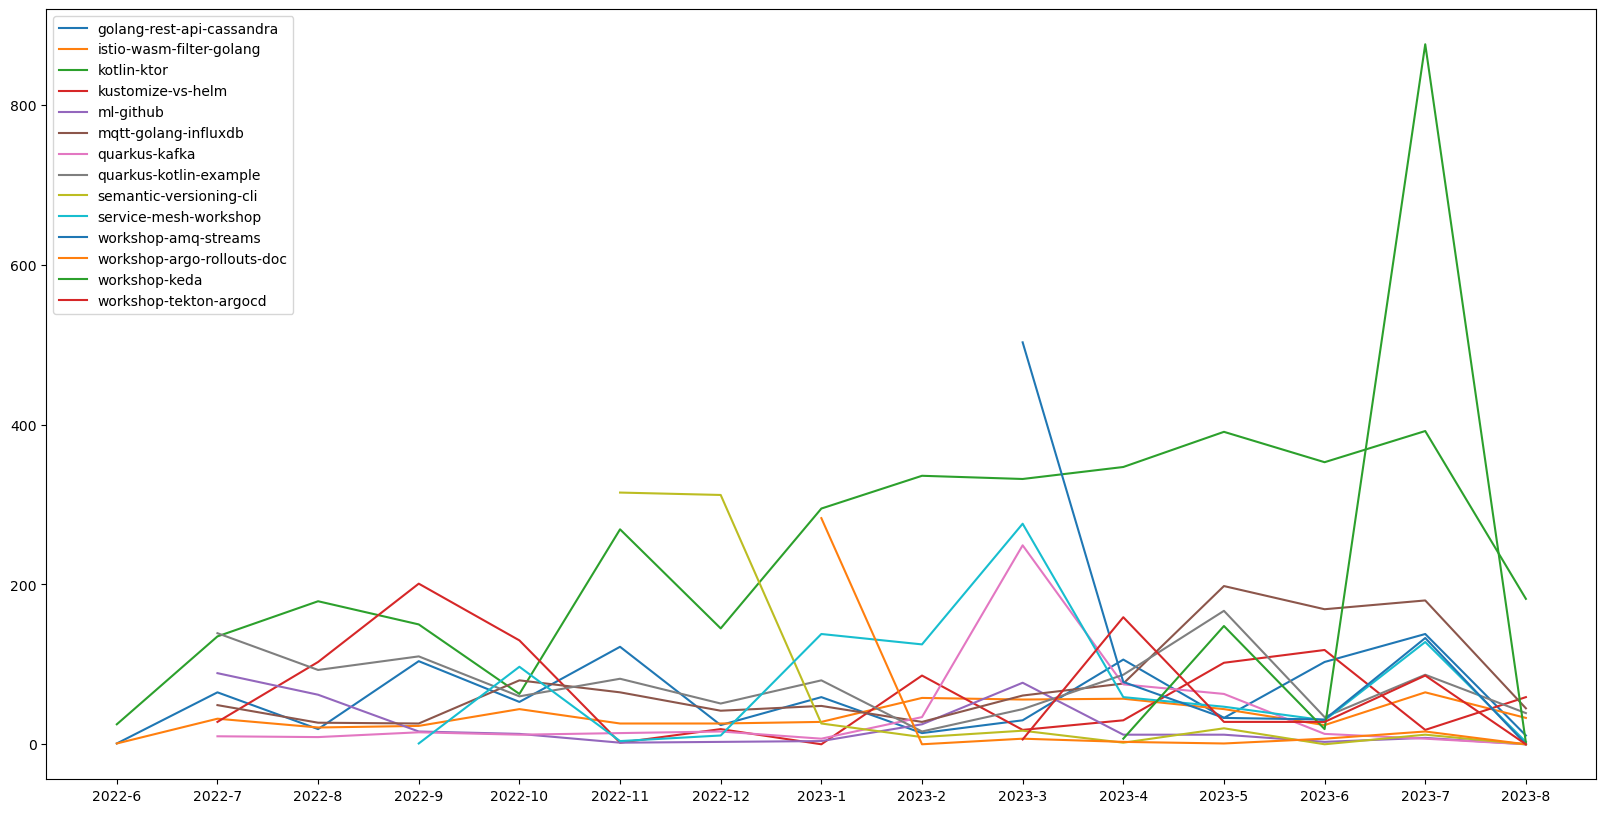

In [15]:
plt.figure(figsize=(20,10))
for repo_name in views_best.index.unique().tolist():
    df_r = df_grouped_by_month[df_grouped_by_month[(       'name',    '')]==repo_name]
    x = df_r[(       'd',    '')]
    y = df_r[('views_total', 'sum')]
    plt.plot(x, y, label=repo_name)
    
plt.legend(loc = "upper left")

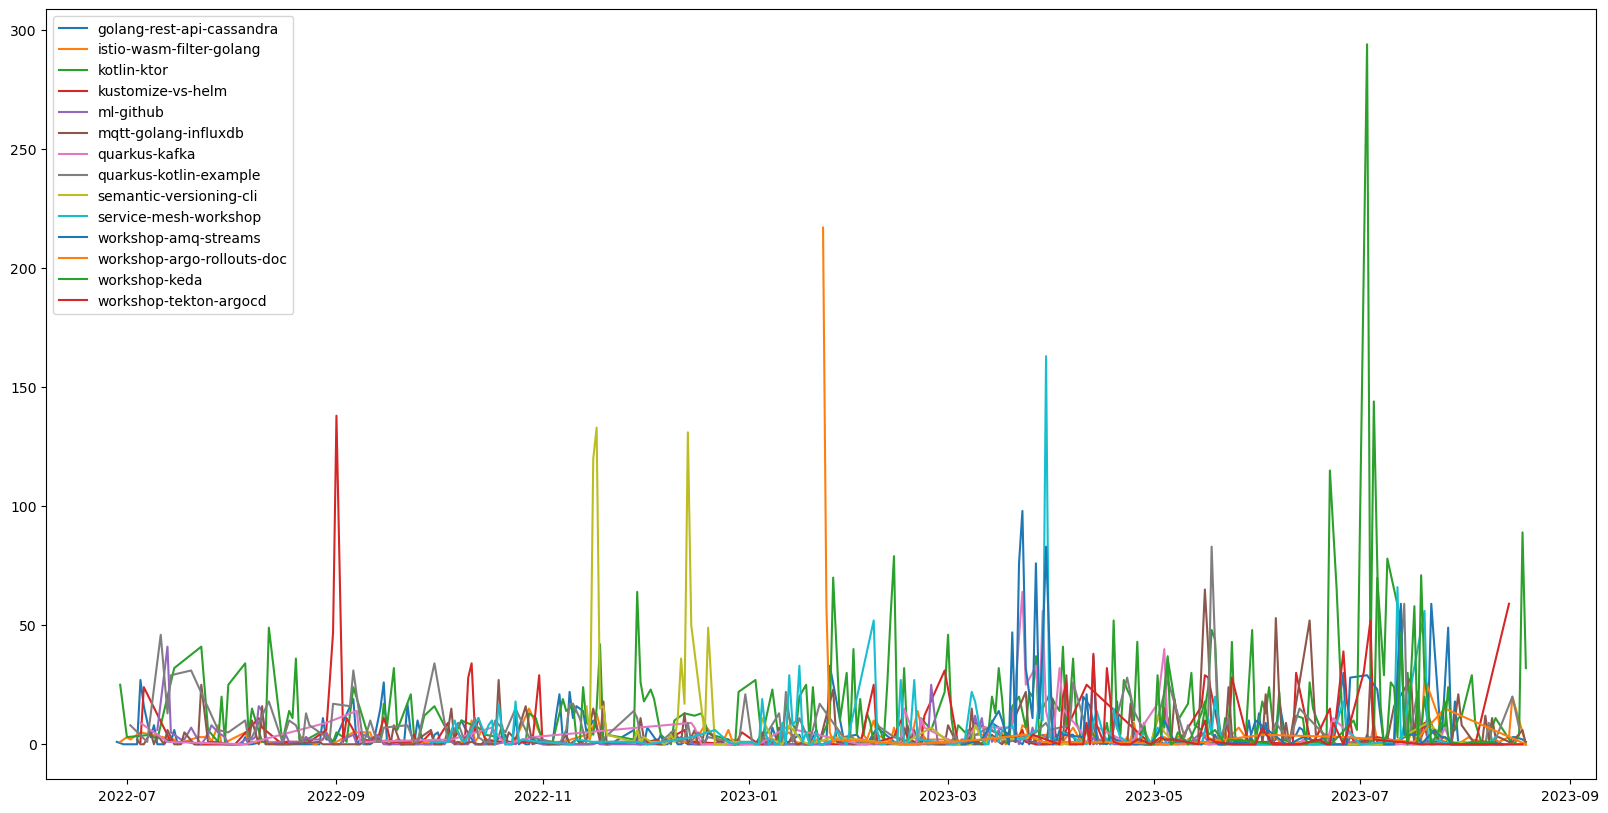

In [16]:
plt.figure(figsize=(20,10))
for repo_name in views_best.index.tolist():
    df_r = dict_df_repos[repo_name].sort_values(by="date")
    x = df_r.date
    y = df_r.views_total
    plt.plot(x, y, label=repo_name)
    
plt.legend(loc = "upper left")

#### Sum views total

In [17]:
df_total_views=df.groupby(['date']).agg({"views_total": ["sum"]}).sort_values(by="date", ascending=True)

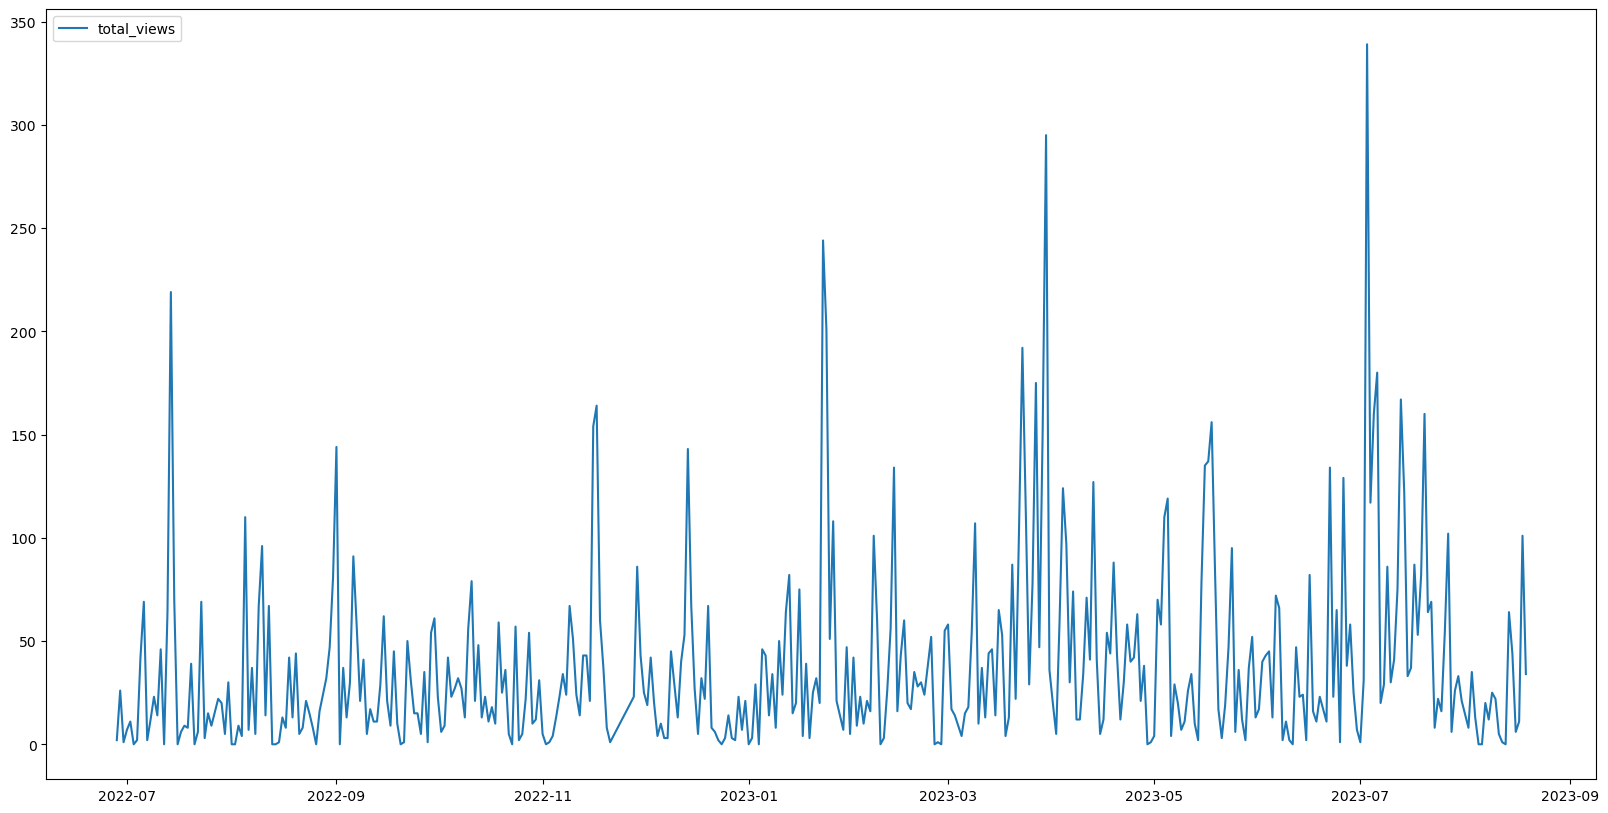

In [18]:
plt.figure(figsize=(20,10))
x = df_total_views.index
y = df_total_views[('views_total', 'sum')]
plt.plot(x, y, label="total_views")
plt.legend(loc = "upper left")

### Clones

In [19]:
# calculate the best 25% repositories
best_clones_quantile = 0.75
worst_clones_quantile = 0.25
best_clones_percentile = df_grouped[('clones_uniques', 'sum')].quantile(best_clones_quantile)
worst_clones_percentile = df_grouped[('clones_uniques', 'sum')].quantile(worst_clones_quantile)
print("Best clones over:", best_clones_percentile)
print("Worst clones under:", worst_clones_percentile)

Best clones over: 47.5
Worst clones under: 24.75


In [20]:
clones=df_grouped[('clones_uniques')]
clones_best = clones[clones['sum'] > best_clones_percentile]
clones_best.sort_values(by='sum', ascending=False)

,sum
name,
golang-rest-api-cassandra,6079
workshop-golang-grpc,4101
mqtt-golang-influxdb,3336
ta,3297
iot-devices-crud,3223
workshop-keda,559
ml-github,393
service-mesh-workshop,137
workshop-tekton-argocd,85


# Stars

In [21]:
# calculate the best 50% repositories
best_stars_quantile = 0.80
worst_stars_quantile = 0.20
best_stars_percentile = df_grouped[('stars_count', 'max')].quantile(best_stars_quantile)
worst_stars_percentile = df_grouped[('stars_count', 'max')].quantile(worst_stars_quantile)
print("Best stars over:", best_stars_percentile)
print("Worst stars under:", worst_stars_percentile)

Best stars over: 1.0
Worst stars under: 0.0


In [22]:
stars=df_grouped[('stars_count')]
stars_best = stars[stars['max'] > best_stars_percentile]
stars_best.sort_values(by=['max'], ascending=False)

,max
name,
mqtt-golang-influxdb,15
kotlin-ktor,8
spring-kotlin-crud,7
kops-aws,4
kustomize-vs-helm,4
semantic-versioning-cli,4
jenkins-ci,3
service-mesh-workshop,3
ta,3


# Red zone

In [23]:
repos = pd.read_csv("./repos.csv")
repos = repos[repos["owner"]==USER]

# remove colum
repos = repos.iloc[:,1:]
# remove owner
#repos = repos.drop(labels="owner",axis=1)
# add num topics
#repos["num_topics"] = len(repos.topics.str.split(','))
def count_topics(topics):
    return 0 if topics.count(',') == 0 else topics.count(',')+1
repos["topics_count"] = repos.apply(lambda row : count_topics(row.topics), axis=1)
# remove topics
repos = repos.drop(labels="topics",axis=1)
# format date
repos["latest_commit_date"] = pd.to_datetime(repos["latest_commit_date"], format='%Y%m%d')
# days until latest commit
today = pd.to_datetime('today')
repos["days_latest_commit"] = (today - repos.latest_commit_date).dt.days
# views
def views_total(name):
    try:
        return df_grouped.loc[name]['views_total']['sum']
    except Exception as e:
        print("[Views] Error ", name, " ==> ", e)
        return 0
repos["views_total"] = repos.apply(lambda row: views_total(row["name"]), axis=1)

#stars
def stars(name):
    try:
        return df_grouped.loc[name][('stars_count')]
    except Exception as e:
        print("[Stars] Error ", name, " ==> ", e)
        return 0
repos["stars_total"] = repos.apply(lambda row: stars(row["name"]), axis=1)

# clones
def clones(name):
    try:
        return df_grouped.loc[name]['clones_uniques']['sum']
    except Exception as e:
        print("[Clones] Error ", name, " ==> ", e)
        return 0
repos["clones_total"] = repos.apply(lambda row: clones(row["name"]), axis=1)

In [24]:
len(repos)

68

In [25]:
# Scores by labels
cut_labels = ['S', 'A', 'B', 'C']
# FIXME ver si es mejor 1 mes, 6 meses 2 años por ejemplo
cut_bins = [0, 
            365/2, # 6 meses
            365, # 1 año
            365*3, # 3 años
            365*99]
repos['score_commits'] = pd.cut(repos['days_latest_commit'], bins=cut_bins, labels=cut_labels, include_lowest=True)

# Topics value
cut_labels = [False, True]
cut_bins = [-1, 0, 99999]
repos['score_topics'] = pd.cut(repos['topics_count'], bins=cut_bins, labels=cut_labels)

# Views score
cut_labels = ['C', 'B', 'A', 'S']
# rank for zero values
repos['views_total'] = repos['views_total'].rank(method='min')
cut_bins = [0, 
            repos['views_total'].quantile(q=0.25),
            repos['views_total'].quantile(q=0.75),
            repos['views_total'].quantile(q=0.9),
            repos['views_total'].quantile(q=1)]
repos['score_views'] = pd.cut(repos['views_total'], bins=cut_bins, labels=cut_labels)

# Clones score
cut_labels = ['C', 'B', 'A', 'S']
repos['clones_total'] = repos['clones_total'].rank(method='min')
cut_bins = [0, 
            repos['clones_total'].quantile(q=0.25),
            repos['clones_total'].quantile(q=0.75),
            repos['clones_total'].quantile(q=0.9),
            repos['clones_total'].quantile(q=1)]
repos['score_clones'] = pd.cut(repos['clones_total'], bins=cut_bins, labels=cut_labels)

# stars
# FIXME this structure have to change because depends of the user
cut_labels = ['C', 'B', 'A', 'S']
cut_bins = [0, 1, 5, 10, 99]
repos['score_stars'] = pd.cut(repos['stars_total'], bins=cut_bins, labels=cut_labels, include_lowest=True)

In [26]:
weights = { 
    'score_commits': {
        'weight': 30,
        'labels': {'S': 100,
                   'A': 70,
                   'B': 25,
                   'C': 0 } 
    },
    'score_topics': {
        'weight': 10,
        'labels': {True: 100,
                   False: 0}
    },
    'score_views':  {
        'weight': 25,
        'labels': {'S': 100,
                   'A': 70,
                   'B': 30,
                   'C': 0 }
    },
    'score_stars':  {
        'weight': 30,
        'labels': {'S': 100,
                   'A': 70,
                   'B': 40,
                   'C': 0 }
    },
    'score_clones':  {
        'weight': 5,
        'labels': {'S': 100,
                   'A': 70,
                   'B': 40,
                   'C': 0 }
    }
}
def score(row):
    score = 0
    for k in weights.keys():
        score += (weights[k]['labels'][row[k]] * weights[k]['weight']/100)
    return score
        
repos["score_total"] = repos.apply(lambda row: score(row), axis=1)
repos = repos.sort_values(by=['score_total'], ascending = False)

In [27]:
table_columns = ['name', 'score_commits', 'score_topics', 'score_views', 'score_stars', 'score_clones', 'score_total']
table = repos[table_columns]
color_c = 'background-color: #c91e1e;'
color_b = 'background-color: #ffc258;'
color_a = 'background-color: #9bc2fd;'
color_s = 'background-color: #5e9400;'
style = table.style.set_table_styles([  
    {'selector': '.S', 'props': color_s},
    {'selector': '.A', 'props': color_a},
    {'selector': '.B', 'props': color_b},
    {'selector': '.C', 'props': color_c},
    {'selector': '.False', 'props': color_c},
    {'selector': '.True', 'props': color_s},
], overwrite=False)

cell_color = pd.DataFrame(table[table_columns],
                          index=repos.index)

style.set_td_classes(cell_color)
style.bar(subset=["score_total",], color='lightgreen')
style.format({'score_total': "{:20,.0f}"})

,name,score_commits,score_topics,score_views,score_stars,score_clones,score_total
29,kustomize-vs-helm,S,True,S,B,A,80
45,service-mesh-workshop,S,True,S,B,A,80
34,mqtt-golang-influxdb,B,True,S,S,S,78
32,ml-github,S,True,A,B,S,74
43,semantic-versioning-cli,A,True,A,B,A,64
11,golang-k8s-helm-helloworld,A,True,A,B,B,62
57,workshop-amq-streams,S,True,A,C,A,61
64,workshop-tekton-argocd,S,True,A,C,A,61
62,workshop-keda,S,False,S,C,S,60
28,kotlin-ktor,C,True,S,A,A,60


In [28]:
print('Puntuación media: ', sum(repos['score_total'])/len(repos))

Puntuación media:  29.91176470588235


In [29]:
df_red_zone = df_grouped[df_grouped[('stars_count', 'max')] <= worst_stars_percentile]
df_red_zone = df_red_zone[df_red_zone[('clones_uniques', 'sum')] <= worst_clones_percentile]
df_red_zone = df_red_zone[df_red_zone[('views_total', 'sum')] <= worst_views_percentile]
df_red_zone.index.values.tolist()

['library',
 'spring-boot-grafana',
 'spring-cloud-eureka',
 'spring-data-mongodb',
 'terraform-aws-demo']